In [180]:
import numpy as np
import math
from scipy.stats import unitary_group
from skimage.measure import block_reduce
from opt_einsum import contract
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
import torch
import time
import sys
import matplotlib.pyplot as plt
from matplotlib import rc
from src.QDDPM_torch import DiffusionModel, QDDPM, naturalDistance
import src.ImageEncode as ie
rc('text', usetex=False)
rc('axes', linewidth=3)

In [181]:
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Torch will use CPU.")

No GPU available. Torch will use CPU.


In [182]:
def generate_training(values: np.array, n_train: int, scale: float, seed=None):
    np.random.seed(seed)
    n = values.size
    noise = abs(np.random.randn(n_train,n))+0j*np.random.randn(n_train,n) 
    print(noise.shape)
    print(values.shape)
    states = (noise*scale) + values
    states/=np.tile(np.linalg.norm(states, axis=1).reshape(1,n_train), (n,1)).T
    return states
    

In [100]:
a = generate_training(normalized, 400, 2)
print(a)

print(a[0][0]**2 + a[0][1]**2 + a[0][2]**2 + a[0][3]**2)

(400, 4)
(4,)
[[0.2242293 +0.j 0.78784638+0.j 0.48495391+0.j 0.30633152+0.j]
 [0.45073058+0.j 0.69604023+0.j 0.30300821+0.j 0.46963387+0.j]
 [0.14654257+0.j 0.42607463+0.j 0.66245492+0.j 0.5984473 +0.j]
 ...
 [0.23294615+0.j 0.3643001 +0.j 0.88555127+0.j 0.16976594+0.j]
 [0.02288165+0.j 0.52212905+0.j 0.27081777+0.j 0.80840301+0.j]
 [0.23918569+0.j 0.14816854+0.j 0.51735519+0.j 0.80819546+0.j]]
(1+0j)


(array([174, 174, 174, 174, 175, 175, 175, 175, 184, 184, 184, 184, 185,
       185, 185, 185, 194, 194, 194, 194, 195, 195, 195, 195, 204, 204,
       204, 204, 205, 205, 205, 205, 214, 214, 214, 214, 215, 215, 215,
       215, 224, 224, 224, 224, 225, 225, 225, 225, 234, 234, 234, 234,
       235, 235, 235, 235, 244, 244, 244, 244, 245, 245, 245, 245, 254,
       254, 254, 254, 255, 255, 255, 255, 264, 264, 264, 264, 265, 265,
       265, 265], dtype=int64), array([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1,
       2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3,
       0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1,
       2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3], dtype=int64))


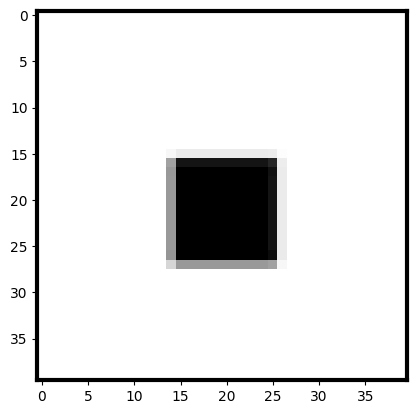

In [206]:
from PIL import Image
scale = 40
img = Image.open('images.png')
img_greyscale = img.convert("L")
img_resized = img_greyscale.resize((scale, scale))

img_array = np.array(img_resized, ndmin = 2)
img_resized.save('dog_resized_greyscale.jpg')

collapsed_array = np.zeros(img_array.size)

for i in range(0, img_array.size):
    collapsed_array[i] = img_array[int(i/40)][i%40]



test_data = np.zeros((int(img_array.size / 4), 4)) + 1j * np.zeros((int(img_array.size / 4), 4))
for i in range(0, int(img_array.size / 4)):
    test_data[i] = ie.normalize(collapsed_array[4*i : 4*i+4]) + 1j * np.zeros(4)

plt.imshow(img_array, cmap='grey',interpolation = 'nearest')

# Find where NaN values are
nan_mask = np.isnan(test_data)

# Get the indices of the NaN values
nan_indices = np.where(nan_mask)

print(nan_indices)

In [184]:
#generate diffusion data
n = 2
T = 20
Ndata = 400

diff_hs = np.linspace(0.5, 4., T)

model_diff = DiffusionModel(n, T, Ndata)
X = torch.from_numpy(test_data)

Xout = np.zeros((T+1, Ndata, 2**n), dtype = np.complex64)
Xout[0] = X
print(X)

for t in range(1, T+1):
    Xout[t] = model_diff.set_diffusionData_t(t, X, diff_hs[:t], seed = t).numpy()
    print(t)

np.save("states_diff", Xout)

tensor([[0.5000+0.j, 0.5000+0.j, 0.5000+0.j, 0.5000+0.j],
        [0.5000+0.j, 0.5000+0.j, 0.5000+0.j, 0.5000+0.j],
        [0.5000+0.j, 0.5000+0.j, 0.5000+0.j, 0.5000+0.j],
        ...,
        [0.5000+0.j, 0.5000+0.j, 0.5000+0.j, 0.5000+0.j],
        [0.5000+0.j, 0.5000+0.j, 0.5000+0.j, 0.5000+0.j],
        [0.5000+0.j, 0.5000+0.j, 0.5000+0.j, 0.5000+0.j]],
       dtype=torch.complex128)
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [187]:
print(Xout)

[[[ 0.5       +0.00000000e+00j  0.5       +0.00000000e+00j
    0.5       +0.00000000e+00j  0.5       +0.00000000e+00j]
  [ 0.5       +0.00000000e+00j  0.5       +0.00000000e+00j
    0.5       +0.00000000e+00j  0.5       +0.00000000e+00j]
  [ 0.5       +0.00000000e+00j  0.5       +0.00000000e+00j
    0.5       +0.00000000e+00j  0.5       +0.00000000e+00j]
  ...
  [ 0.5       +0.00000000e+00j  0.5       +0.00000000e+00j
    0.5       +0.00000000e+00j  0.5       +0.00000000e+00j]
  [ 0.5       +0.00000000e+00j  0.5       +0.00000000e+00j
    0.5       +0.00000000e+00j  0.5       +0.00000000e+00j]
  [ 0.5       +0.00000000e+00j  0.5       +0.00000000e+00j
    0.5       +0.00000000e+00j  0.5       +0.00000000e+00j]]

 [[ 0.45739585-9.02355462e-03j  0.46795064+1.43763684e-02j
    0.52751553+2.98622474e-02j  0.5399616 -2.82893814e-02j]
  [ 0.46113116-2.76158303e-02j  0.521137  +1.14638180e-01j
    0.45828184-7.05997720e-02j  0.5347051 -3.08782440e-02j]
  [ 0.49260247-2.67638685e-03j  0.427666

In [203]:
states_diff = np.load('states_diff.npy')

fidelity = np.zeros((T + 1, Ndata))
for i in range(0, T + 1):
    for j in range(0, Ndata):
        fidelity[i][j] = np.abs(np.vdot(states_diff[i][j], states_diff[0][j])) ** 2

fidelity_mean = np.mean(fidelity, axis = 1)

True

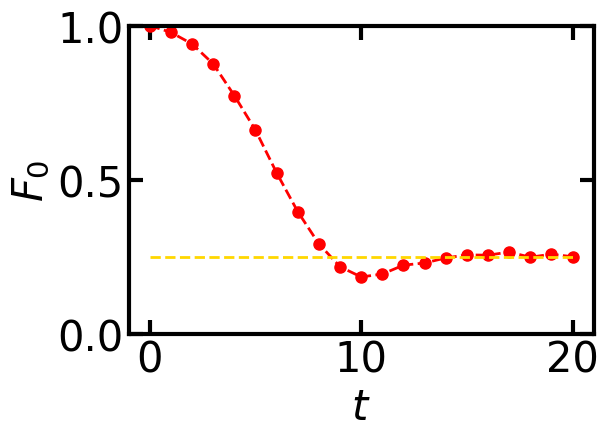

In [198]:
# visualize the fidelity decay in the diffusion process
n = 2
T = 20
Ndata = 400
states_diff = np.load('states_diff.npy')

fig, ax = plt.subplots(figsize=(6, 4))
indices = np.random.permutation(Ndata)

ax.plot(range(T+1), fidelity_mean, 'o--', markersize=8, lw=2, c='r')
ax.plot(range(T+1), 0.25*np.ones(T+1), '--', lw=2, c='gold')
ax.set_ylabel(r'$F_0$', fontsize=30)
ax.set_xlabel(r'$t$', fontsize=30)
ax.set_ylim(0,1)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)

In [199]:
def Training_t(model, t, inputs_T, params_tot, Ndata, epochs):
    '''
    the trianing for the backward PQC at step t
    input_tplus1: the output from step t+1, as the role of input at step t
    Args:
    model: the QDDPM model
    t: the diffusion step
    inputs_T: the input data at step t=T
    params_tot: collection of PQC parameters before step t
    Ndata: number of samples in dataset
    epochs: the number of iterations
    '''
    input_tplus1 = model.prepareInput_t(inputs_T, params_tot, t, Ndata) # prepare input
    states_diff = model.states_diff
    loss_hist = [] # record of training history

    # initialize parameters
    np.random.seed()
    params_t = torch.tensor(np.random.normal(size=2 * model.n_tot * model.L), requires_grad=True)
    # set optimizer and learning rate decay
    optimizer = torch.optim.Adam([params_t], lr=0.0005)
    
    t0 = time.time()
    for step in range(epochs):
        indices = np.random.choice(states_diff.shape[1], size=Ndata, replace=False)
        true_data = states_diff[t, indices]

        output_t = model.backwardOutput_t(input_tplus1, params_t)
        loss = naturalDistance(output_t, true_data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_hist.append(loss) # record the current loss
        
        if step%100 == 0:
            loss_value = loss_hist[-1]
            print("Step %s, loss: %s, time elapsed: %s seconds"%(step, loss_value, time.time() - t0))

    return params_t, torch.stack(loss_hist)

In [200]:
#train on diffusion data
n, na = 2, 1 # number of data and ancilla qubits
T = 20 # number of diffusion steps
L = 6 # layer of backward PQC
Ndata = 400 # number of data in the training data set
epochs = 2001 # number of training epochs

#gen random samples at t = T
diffModel = DiffusionModel(n, T, Ndata)
inputs_T = diffModel.HaarSampleGeneration(Ndata, seed = 22)

#load diffusion process
states_diff = np.load('states_diff.npy')

model = QDDPM(n=n, na=na, T=T, L=L)
model.set_diffusionSet(states_diff)

params_total = []
loss_hist_total = []

for t in range(T - 1, -1, -1):
    params_tot = np.zeros((T, 2*(n+na)*L))
    for tt in range(t+1, 20):
        print(tt)
        params_tot[tt] = np.load('params_t%d.npy'%tt)
    
    params, loss_hist = Training_t(model, t, inputs_T, params_tot, Ndata, epochs)

    np.save('params_t%d'%t, params.detach().numpy())
    np.save('loss_t%d'%t, loss_hist.detach().numpy())
    
    #params_total = np.append(params_total, params, axis = 1)
    #loss_hist_total = np.append(loss_hist_total, loss_hist, axis = 1)


Step 0, loss: tensor(nan, grad_fn=<SubBackward0>), time elapsed: 0.01694321632385254 seconds


RuntimeError: probability tensor contains either `inf`, `nan` or element < 0

In [108]:
n, na = 2, 1
T = 20
L = 6
Ndata = 400
epochs = 2001

params_tot = np.zeros((T, 2*(n+na)*L))
loss_tot = np.zeros((T, epochs))
f0_tot = np.zeros((T, epochs))

for t in range(T):
    params_tot[t] = np.load('params_t%d.npy'%t)
    loss_tot[t] = np.load('loss_t%d.npy'%t)
    

np.save("params_total", params_tot)
np.save("loss_tot", loss_tot)                            

In [174]:
#use model to predict what original image was
test_data_T20 = torch.tensor(Xout[20], dtype = torch.complex64)

n, na = 2, 1
T = 20
L = 6
Ndata = 400

diffModel = DiffusionModel(n, T, Ndata)

params_tot = np.load('params_total.npy')

model = QDDPM(n=n, na=na, T=T, L=L)

data_te = model.backDataGeneration(test_data_T20, params_tot, Ndata)[:, :, :2**n].numpy()

np.save("test_backwardsgen", data_te)

In [175]:
backwards_gen = np.load('test_backwardsgen.npy')
print(backwards_gen[20])

[[-0.03893866+0.29942936j  0.5238452 -0.09522967j -0.45174214+0.62380683j
  -0.13201904-0.12127586j]
 [ 0.5235849 -0.19254854j  0.00763049+0.0602373j   0.26377743+0.580449j
  -0.03514398-0.52665216j]
 [ 0.3550071 -0.01686153j  0.21404457-0.3024806j   0.4907567 -0.53825945j
  -0.2695129 +0.36492968j]
 ...
 [ 0.47715595+0.2524841j  -0.12119724+0.4844882j   0.16146074-0.1377298j
  -0.39973032-0.5043139j ]
 [-0.09568009+0.05633598j  0.3462438 -0.6704373j   0.09490029-0.09644374j
   0.5894566 +0.22920303j]
 [ 0.16245832-0.4360507j   0.10294865+0.18537325j  0.01657556-0.82167965j
   0.01395482+0.2507577j ]]


In [178]:
backwards_gen = np.load('test_backwardsgen.npy')

for z in range(0, 21):
    final_output_flattened = backwards_gen[0]
    final_output_flattened = np.abs(final_output_flattened) * 255
    final_output_flattened = final_output_flattened.flatten()

    dim = int((final_output_flattened.size) ** 0.5)

    final_output_nxn = np.zeros((dim, dim))

    for i in range(0, dim):
        for j in range(0, dim):
            final_output_nxn[i][j] = round(final_output_flattened[(i*40) + j])



[[-0.03893866+0.29942936j  0.5238452 -0.09522967j -0.45174214+0.62380683j
  -0.13201904-0.12127586j]
 [ 0.5235849 -0.19254854j  0.00763049+0.0602373j   0.26377743+0.580449j
  -0.03514398-0.52665216j]
 [ 0.3550071 -0.01686153j  0.21404457-0.3024806j   0.4907567 -0.53825945j
  -0.2695129 +0.36492968j]
 ...
 [ 0.47715595+0.2524841j  -0.12119724+0.4844882j   0.16146074-0.1377298j
  -0.39973032-0.5043139j ]
 [-0.09568009+0.05633598j  0.3462438 -0.6704373j   0.09490029-0.09644374j
   0.5894566 +0.22920303j]
 [ 0.16245832-0.4360507j   0.10294865+0.18537325j  0.01657556-0.82167965j
   0.01395482+0.2507577j ]]


[[ 69. 138. 150. ... 127. 134. 153.]
 [101. 119. 156. ... 120.  81. 166.]
 [222. 109.  44. ... 120. 111. 158.]
 ...
 [120. 144. 127. ... 127. 134. 140.]
 [139. 118. 143. ... 104. 175. 127.]
 [132. 106. 104. ... 127. 138. 124.]]


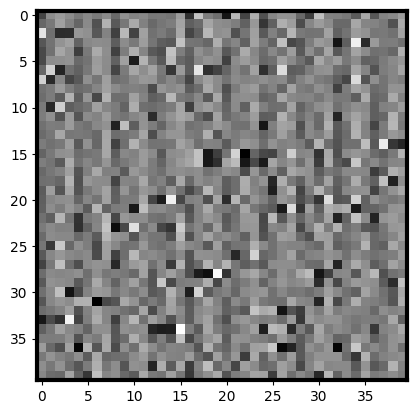

In [179]:
print(final_output_nxn)
plt.imshow(final_output_nxn, cmap = 'grey', interpolation = 'nearest')

[[0.   0.33]
 [0.66 0.99]]


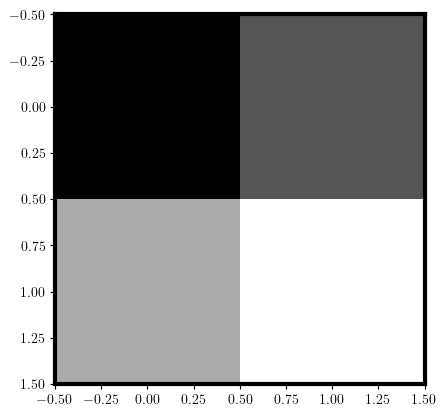

[0.        +0.j 0.26726124+0.j 0.53452248+0.j 0.80178373+0.j]


In [20]:
values = np.array([pixelValues[0:2], pixelValues[2:4]])
print(values)
normalized = ie.normalize(values)
plt.imshow(values, cmap='grey', interpolation='nearest')
plt.show()
normalized = normalized.ravel() + 0j*np.zeros(4)
print(normalized)
